# DANL 320 Project

Website: https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets

Github: https://danielxu12.github.io


#Setting

In [ ]:
# Below is for an interactive display of Pandas DataFrame in Colab
from google.colab import data_table
data_table.enable_dataframe_formatter()

from tabulate import tabulate  # for table summary

# For basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm  # for lowess smoothing

# `scikit-learn`
from sklearn.metrics import mean_squared_error
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score)
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.inspection import PartialDependenceDisplay

from sklearn.preprocessing import scale # zero mean & one s.d.
from sklearn.linear_model import LassoCV, lasso_path
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBRegressor, plot_importance

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, pow, mean, avg, when, log, sqrt, exp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
def add_dummy_variables(var_name, reference_level, category_order=None):
    """
    Creates dummy variables for the specified column in the global DataFrames dtrain and dtest.
    Allows manual setting of category order.

    Parameters:
        var_name (str): The name of the categorical column (e.g., "borough_name").
        reference_level (int): Index of the category to be used as the reference (dummy omitted).
        category_order (list, optional): List of categories in the desired order. If None, categories are sorted.

    Returns:
        dummy_cols (list): List of dummy column names excluding the reference category.
        ref_category (str): The category chosen as the reference.
    """
    global dtrain, dtest

    # Get distinct categories from the training set.
    categories = dtrain.select(var_name).distinct().rdd.flatMap(lambda x: x).collect()

    # Convert booleans to strings if present.
    categories = [str(c) if isinstance(c, bool) else c for c in categories]

    # Use manual category order if provided; otherwise, sort categories.
    if category_order:
        # Ensure all categories are present in the user-defined order
        missing = set(categories) - set(category_order)
        if missing:
            raise ValueError(f"These categories are missing from your custom order: {missing}")
        categories = category_order
    else:
        categories = sorted(categories)

    # Validate reference_level
    if reference_level < 0 or reference_level >= len(categories):
        raise ValueError(f"reference_level must be between 0 and {len(categories) - 1}")

    # Define the reference category
    ref_category = categories[reference_level]
    print("Reference category (dummy omitted):", ref_category)

    # Create dummy variables for all categories
    for cat in categories:
        dummy_col_name = var_name + "_" + str(cat).replace(" ", "_")
        dtrain = dtrain.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))
        dtest = dtest.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))

    # List of dummy columns, excluding the reference category
    dummy_cols = [var_name + "_" + str(cat).replace(" ", "_") for cat in categories if cat != ref_category]

    return dummy_cols, ref_category


# Example usage without category_order:
# dummy_cols_year, ref_category_year = add_dummy_variables('year', 0)

# Example usage with category_order:
# custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
# dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

In [ ]:
def regression_table(model, assembler):
    """
    Creates a formatted regression table from a fitted LinearRegression model and its VectorAssembler.

    If the model’s labelCol (retrieved using getLabelCol()) starts with "log", an extra column showing np.exp(coeff)
    is added immediately after the beta estimate column for predictor rows. Additionally, np.exp() of the 95% CI
    Lower and Upper bounds is also added unless the predictor's name includes "log_". The Intercept row does not
    include exponentiated values.

    When labelCol starts with "log", the columns are ordered as:
        y: [label] | Beta | Exp(Beta) | Sig. | Std. Error | p-value | 95% CI Lower | Exp(95% CI Lower) | 95% CI Upper | Exp(95% CI Upper)

    Otherwise, the columns are:
        y: [label] | Beta | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper

    Parameters:
        model: A fitted LinearRegression model (with a .summary attribute and a labelCol).
        assembler: The VectorAssembler used to assemble the features for the model.

    Returns:
        A formatted string containing the regression table.
    """
    # Determine if we should display exponential values for coefficients.
    is_log = model.getLabelCol().lower().startswith("log")

    # Extract coefficients and standard errors as NumPy arrays.
    coeffs = model.coefficients.toArray()
    std_errors_all = np.array(model.summary.coefficientStandardErrors)

    # Check if the intercept's standard error is included (one extra element).
    if len(std_errors_all) == len(coeffs) + 1:
        intercept_se = std_errors_all[0]
        std_errors = std_errors_all[1:]
    else:
        intercept_se = None
        std_errors = std_errors_all

    # Use provided tValues and pValues.
    df = model.summary.numInstances - len(coeffs) - 1
    t_critical = stats.t.ppf(0.975, df)
    p_values = model.summary.pValues

    # Helper: significance stars.
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Build table rows for each feature.
    table = []
    for feature, beta, se, p in zip(assembler.getInputCols(), coeffs, std_errors, p_values):
        ci_lower = beta - t_critical * se
        ci_upper = beta + t_critical * se

        # Check if predictor contains "log_" to determine if exponentiation should be applied
        apply_exp = is_log and "log_" not in feature.lower()

        exp_beta = np.exp(beta) if apply_exp else ""
        exp_ci_lower = np.exp(ci_lower) if apply_exp else ""
        exp_ci_upper = np.exp(ci_upper) if apply_exp else ""

        if is_log:
            table.append([
                feature,            # Predictor name
                beta,               # Beta estimate
                exp_beta,           # Exponential of beta (or blank)
                significance_stars(p),
                se,
                p,
                ci_lower,
                exp_ci_lower,       # Exponential of 95% CI lower bound
                ci_upper,
                exp_ci_upper        # Exponential of 95% CI upper bound
            ])
        else:
            table.append([
                feature,
                beta,
                significance_stars(p),
                se,
                p,
                ci_lower,
                ci_upper
            ])

    # Process intercept.
    if intercept_se is not None:
        intercept_p = model.summary.pValues[0] if model.summary.pValues is not None else None
        intercept_sig = significance_stars(intercept_p)
        ci_intercept_lower = model.intercept - t_critical * intercept_se
        ci_intercept_upper = model.intercept + t_critical * intercept_se
    else:
        intercept_sig = ""
        ci_intercept_lower = ""
        ci_intercept_upper = ""
        intercept_se = ""

    if is_log:
        table.append([
            "Intercept",
            model.intercept,
            "",                    # Removed np.exp(model.intercept)
            intercept_sig,
            intercept_se,
            "",
            ci_intercept_lower,
            "",
            ci_intercept_upper,
            ""
        ])
    else:
        table.append([
            "Intercept",
            model.intercept,
            intercept_sig,
            intercept_se,
            "",
            ci_intercept_lower,
            ci_intercept_upper
        ])

    # Append overall model metrics.
    if is_log:
        table.append(["Observations", model.summary.numInstances, "", "", "", "", "", "", "", ""])
        table.append(["R²", model.summary.r2, "", "", "", "", "", "", "", ""])
        table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", "", "", "", ""])
    else:
        table.append(["Observations", model.summary.numInstances, "", "", "", "", ""])
        table.append(["R²", model.summary.r2, "", "", "", "", ""])
        table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", ""])

    # Format the table rows.
    formatted_table = []
    for row in table:
        formatted_row = []
        for i, item in enumerate(row):
            # Format Observations as integer with commas.
            if row[0] == "Observations" and i == 1 and isinstance(item, (int, float, np.floating)) and item != "":
                formatted_row.append(f"{int(item):,}")
            elif isinstance(item, (int, float, np.floating)) and item != "":
                if is_log:
                    # When is_log, the columns are:
                    # 0: Metric, 1: Beta, 2: Exp(Beta), 3: Sig, 4: Std. Error, 5: p-value,
                    # 6: 95% CI Lower, 7: Exp(95% CI Lower), 8: 95% CI Upper, 9: Exp(95% CI Upper).
                    if i in [1, 2, 4, 6, 7, 8, 9]:
                        formatted_row.append(f"{item:,.3f}")
                    elif i == 5:
                        formatted_row.append(f"{item:.3f}")
                    else:
                        formatted_row.append(f"{item:.3f}")
                else:
                    # When not is_log, the columns are:
                    # 0: Metric, 1: Beta, 2: Sig, 3: Std. Error, 4: p-value, 5: 95% CI Lower, 6: 95% CI Upper.
                    if i in [1, 3, 5, 6]:
                        formatted_row.append(f"{item:,.3f}")
                    elif i == 4:
                        formatted_row.append(f"{item:.3f}")
                    else:
                        formatted_row.append(f"{item:.3f}")
            else:
                formatted_row.append(item)
        formatted_table.append(formatted_row)

    # Set header and column alignment based on whether label starts with "log"
    if is_log:
        headers = [
            f"y: {model.getLabelCol()}",
            "Beta", "Exp(Beta)", "Sig.", "Std. Error", "p-value",
            "95% CI Lower", "Exp(95% CI Lower)", "95% CI Upper", "Exp(95% CI Upper)"
        ]
        colalign = ("left", "right", "right", "center", "right", "right", "right", "right", "right", "right")
    else:
        headers = [f"y: {model.getLabelCol()}", "Beta", "Sig.", "Std. Error", "p-value", "95% CI Lower", "95% CI Upper"]
        colalign = ("left", "right", "center", "right", "right", "right", "right")

    table_str = tabulate(
        formatted_table,
        headers=headers,
        tablefmt="pretty",
        colalign=colalign
    )

    # Insert a dashed line after the Intercept row.
    lines = table_str.split("\n")
    dash_line = '-' * len(lines[0])
    for i, line in enumerate(lines):
        if "Intercept" in line and not line.strip().startswith('+'):
            lines.insert(i+1, dash_line)
            break

    return "\n".join(lines)

# Example usage:
# print(regression_table(model_1, assembler_1))

In [ ]:
import pandas as pd
import numpy as np
from tabulate import tabulate  # for table summary
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # for lowess smoothing

from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, pow, mean, avg, when, log, sqrt, exp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
def regression_table(model, assembler):
    """
    Creates a formatted regression table from a fitted LinearRegression model and its VectorAssembler.

    If the model’s labelCol (retrieved using getLabelCol()) starts with "log", an extra column showing np.exp(coeff)
    is added immediately after the beta estimate column for predictor rows. Additionally, np.exp() of the 95% CI
    Lower and Upper bounds is also added unless the predictor's name includes "log_". The Intercept row does not
    include exponentiated values.

    When labelCol starts with "log", the columns are ordered as:
        y: [label] | Beta | Exp(Beta) | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper | Exp(95% CI Lower) | Exp(95% CI Upper)

    Otherwise, the columns are:
        y: [label] | Beta | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper

    Parameters:
        model: A fitted LinearRegression model (with a .summary attribute and a labelCol).
        assembler: The VectorAssembler used to assemble the features for the model.

    Returns:
        A formatted string containing the regression table.
    """
    # Determine if we should display exponential values for coefficients.
    is_log = model.getLabelCol().lower().startswith("log")

    # Extract coefficients and standard errors as NumPy arrays.
    coeffs = model.coefficients.toArray()
    std_errors_all = np.array(model.summary.coefficientStandardErrors)

    # Check if the intercept's standard error is included (one extra element).
    if len(std_errors_all) == len(coeffs) + 1:
        intercept_se = std_errors_all[0]
        std_errors = std_errors_all[1:]
    else:
        intercept_se = None
        std_errors = std_errors_all

    # Use provided tValues and pValues.
    df = model.summary.numInstances - len(coeffs) - 1
    t_critical = stats.t.ppf(0.975, df)
    p_values = model.summary.pValues

    # Helper: significance stars.
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Build table rows for each feature.
    table = []
    for feature, beta, se, p in zip(assembler.getInputCols(), coeffs, std_errors, p_values):
        ci_lower = beta - t_critical * se
        ci_upper = beta + t_critical * se

        # Check if predictor contains "log_" to determine if exponentiation should be applied
        apply_exp = is_log and "log_" not in feature.lower()

        exp_beta = np.exp(beta) if apply_exp else ""
        exp_ci_lower = np.exp(ci_lower) if apply_exp else ""
        exp_ci_upper = np.exp(ci_upper) if apply_exp else ""

        if is_log:
            table.append([
                feature,            # Predictor name
                beta,               # Beta estimate
                exp_beta,           # Exponential of beta (or blank)
                significance_stars(p),
                se,
                p,
                ci_lower,
                ci_upper,
                exp_ci_lower,       # Exponential of 95% CI lower bound
                exp_ci_upper        # Exponential of 95% CI upper bound
            ])
        else:
            table.append([
                feature,
                beta,
                significance_stars(p),
                se,
                p,
                ci_lower,
                ci_upper
            ])

    # Process intercept.
    if intercept_se is not None:
        intercept_p = model.summary.pValues[0] if model.summary.pValues is not None else None
        intercept_sig = significance_stars(intercept_p)
        ci_intercept_lower = model.intercept - t_critical * intercept_se
        ci_intercept_upper = model.intercept + t_critical * intercept_se
    else:
        intercept_sig = ""
        ci_intercept_lower = ""
        ci_intercept_upper = ""
        intercept_se = ""

    if is_log:
        table.append([
            "Intercept",
            model.intercept,
            "",                    # Removed np.exp(model.intercept)
            intercept_sig,
            intercept_se,
            "",
            ci_intercept_lower,
            "",
            ci_intercept_upper,
            ""
        ])
    else:
        table.append([
            "Intercept",
            model.intercept,
            intercept_sig,
            intercept_se,
            "",
            ci_intercept_lower,
            ci_intercept_upper
        ])

    # Append overall model metrics.
    if is_log:
        table.append(["Observations", model.summary.numInstances, "", "", "", "", "", "", "", ""])
        table.append(["R²", model.summary.r2, "", "", "", "", "", "", "", ""])
        table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", "", "", "", ""])
    else:
        table.append(["Observations", model.summary.numInstances, "", "", "", "", ""])
        table.append(["R²", model.summary.r2, "", "", "", "", ""])
        table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", ""])

    # Format the table rows.
    formatted_table = []
    for row in table:
        formatted_row = []
        for i, item in enumerate(row):
            # Format Observations as integer with commas.
            if row[0] == "Observations" and i == 1 and isinstance(item, (int, float, np.floating)) and item != "":
                formatted_row.append(f"{int(item):,}")
            elif isinstance(item, (int, float, np.floating)) and item != "":
                if is_log:
                    # When is_log, the columns are:
                    # 0: Metric, 1: Beta, 2: Exp(Beta), 3: Sig, 4: Std. Error, 5: p-value,
                    # 6: 95% CI Lower, 7: 95% CI Upper, 8: Exp(95% CI Lower), 9: Exp(95% CI Upper).
                    if i in [1, 2, 4, 6, 7, 8, 9]:
                        formatted_row.append(f"{item:,.3f}")
                    elif i == 5:
                        formatted_row.append(f"{item:.3f}")
                    else:
                        formatted_row.append(f"{item:.3f}")
                else:
                    # When not is_log, the columns are:
                    # 0: Metric, 1: Beta, 2: Sig, 3: Std. Error, 4: p-value, 5: 95% CI Lower, 6: 95% CI Upper.
                    if i in [1, 3, 5, 6]:
                        formatted_row.append(f"{item:,.3f}")
                    elif i == 4:
                        formatted_row.append(f"{item:.3f}")
                    else:
                        formatted_row.append(f"{item:.3f}")
            else:
                formatted_row.append(item)
        formatted_table.append(formatted_row)

    # Set header and column alignment based on whether label starts with "log"
    if is_log:
        headers = [
            f"y: {model.getLabelCol()}",
            "Beta", "Exp(Beta)", "Sig.", "Std. Error", "p-value",
            "95% CI Lower", "95% CI Upper", "Exp(95% CI Lower)", "Exp(95% CI Upper)"
        ]
        colalign = ("left", "right", "right", "center", "right", "right", "right", "right", "right", "right")
    else:
        headers = [f"y: {model.getLabelCol()}", "Beta", "Sig.", "Std. Error", "p-value", "95% CI Lower", "95% CI Upper"]
        colalign = ("left", "right", "center", "right", "right", "right", "right")

    table_str = tabulate(
        formatted_table,
        headers=headers,
        tablefmt="pretty",
        colalign=colalign
    )

    # Insert a dashed line after the Intercept row.
    lines = table_str.split("\n")
    dash_line = '-' * len(lines[0])
    for i, line in enumerate(lines):
        if "Intercept" in line and not line.strip().startswith('+'):
            lines.insert(i+1, dash_line)
            break

    return "\n".join(lines)

# Example usage:
# print(regression_table(model_1, assembler_1))

In [ ]:
def add_dummy_variables(var_name, reference_level, category_order=None):
    """
    Creates dummy variables for the specified column in the global DataFrames dtrain and dtest.
    Allows manual setting of category order.

    Parameters:
        var_name (str): The name of the categorical column (e.g., "borough_name").
        reference_level (int): Index of the category to be used as the reference (dummy omitted).
        category_order (list, optional): List of categories in the desired order. If None, categories are sorted.

    Returns:
        dummy_cols (list): List of dummy column names excluding the reference category.
        ref_category (str): The category chosen as the reference.
    """
    global dtrain, dtest

    # Get distinct categories from the training set.
    categories = dtrain.select(var_name).distinct().rdd.flatMap(lambda x: x).collect()

    # Convert booleans to strings if present.
    categories = [str(c) if isinstance(c, bool) else c for c in categories]

    # Use manual category order if provided; otherwise, sort categories.
    if category_order:
        # Ensure all categories are present in the user-defined order
        missing = set(categories) - set(category_order)
        if missing:
            raise ValueError(f"These categories are missing from your custom order: {missing}")
        categories = category_order
    else:
        categories = sorted(categories)

    # Validate reference_level
    if reference_level < 0 or reference_level >= len(categories):
        raise ValueError(f"reference_level must be between 0 and {len(categories) - 1}")

    # Define the reference category
    ref_category = categories[reference_level]
    print("Reference category (dummy omitted):", ref_category)

    # Create dummy variables for all categories
    for cat in categories:
        dummy_col_name = var_name + "_" + str(cat).replace(" ", "_")
        dtrain = dtrain.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))
        dtest = dtest.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))

    # List of dummy columns, excluding the reference category
    dummy_cols = [var_name + "_" + str(cat).replace(" ", "_") for cat in categories if cat != ref_category]

    return dummy_cols, ref_category


# Example usage without category_order:
# dummy_cols_year, ref_category_year = add_dummy_variables('year', 0)

# Example usage with category_order:
# custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
# dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

In [ ]:
def add_interaction_terms(var_list1, var_list2, var_list3=None):
    """
    Creates interaction term columns in the global DataFrames dtrain and dtest.

    For two sets of variable names (which may represent categorical (dummy) or continuous variables),
    this function creates two-way interactions by multiplying each variable in var_list1 with each
    variable in var_list2.

    Optionally, if a third list of variable names (var_list3) is provided, the function also creates
    three-way interactions among each variable in var_list1, each variable in var_list2, and each variable
    in var_list3.

    Parameters:
        var_list1 (list): List of column names for the first set of variables.
        var_list2 (list): List of column names for the second set of variables.
        var_list3 (list, optional): List of column names for the third set of variables for three-way interactions.

    Returns:
        A flat list of new interaction column names.
    """
    global dtrain, dtest

    interaction_cols = []

    # Create two-way interactions between var_list1 and var_list2.
    for var1 in var_list1:
        for var2 in var_list2:
            col_name = f"{var1}_*_{var2}"
            dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double"))
            dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double"))
            interaction_cols.append(col_name)

    # Create two-way interactions between var_list1 and var_list3.
    if var_list3 is not None:
      for var1 in var_list1:
          for var3 in var_list3:
              col_name = f"{var1}_*_{var3}"
              dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var3).cast("double"))
              dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var3).cast("double"))
              interaction_cols.append(col_name)

    # Create two-way interactions between var_list2 and var_list3.
    if var_list3 is not None:
      for var2 in var_list2:
          for var3 in var_list3:
              col_name = f"{var2}_*_{var3}"
              dtrain = dtrain.withColumn(col_name, col(var2).cast("double") * col(var3).cast("double"))
              dtest = dtest.withColumn(col_name, col(var2).cast("double") * col(var3).cast("double"))
              interaction_cols.append(col_name)

    # If a third list is provided, create three-way interactions.
    if var_list3 is not None:
        for var1 in var_list1:
            for var2 in var_list2:
                for var3 in var_list3:
                    col_name = f"{var1}_*_{var2}_*_{var3}"
                    dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double") * col(var3).cast("double"))
                    dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double") * col(var3).cast("double"))
                    interaction_cols.append(col_name)

    return interaction_cols

 # Example
 # interaction_cols_brand_price = add_interaction_terms(dummy_cols_brand, ['log_price'])
 # interaction_cols_brand_ad_price = add_interaction_terms(dummy_cols_brand, dummy_cols_ad, ['log_price'])

In [ ]:
def compare_reg_models(models, assemblers, names=None):
    """
    Produces a single formatted table comparing multiple regression models.

    For each predictor (the union across models, ordered by first appearance), the table shows
    the beta estimate (with significance stars) from each model (blank if not used).
    For a predictor, if a model's outcome (model.getLabelCol()) starts with "log", the cell displays
    both the beta and its exponential (separated by " / "), except when the predictor's name includes "log_".
    (The intercept row does not display exp(.))

    Additional rows for Intercept, Observations, R², and RMSE are appended.

    The header's first column is labeled "Predictor", and subsequent columns are
    "y: [outcome] ([name])" for each model.

    The table is produced in grid format (with vertical lines). A dashed line (using '-' characters)
    is inserted at the top, immediately after the header, and at the bottom.
    Additionally, immediately after the Intercept row, the border line is replaced with one using '='
    (to appear as, for example, "+==============================================+==========================+...").

    Parameters:
        models (list): List of fitted LinearRegression models.
        assemblers (list): List of corresponding VectorAssembler objects.
        names (list, optional): List of model names; defaults to "Model 1", "Model 2", etc.

    Returns:
        A formatted string containing the combined regression table.
    """
    # Default model names.
    if names is None:
        names = [f"Model {i+1}" for i in range(len(models))]

    # For each model, get outcome and determine if that model is log-transformed.
    outcomes = [m.getLabelCol() for m in models]
    is_log_flags = [out.lower().startswith("log") for out in outcomes]

    # Build an ordered union of predictors based on first appearance.
    ordered_predictors = []
    for assembler in assemblers:
        for feat in assembler.getInputCols():
            if feat not in ordered_predictors:
                ordered_predictors.append(feat)

    # Helper for significance stars.
    def significance_stars(p):
        if p is None:
            return ""
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Build rows for each predictor.
    rows = []
    for feat in ordered_predictors:
        row = [feat]
        for m, a, is_log in zip(models, assemblers, is_log_flags):
            feats_model = a.getInputCols()
            if feat in feats_model:
                idx = feats_model.index(feat)
                beta = m.coefficients.toArray()[idx]
                p_val = m.summary.pValues[idx] if m.summary.pValues is not None else None
                stars = significance_stars(p_val)
                cell = f"{beta:.3f}{stars}"
                # Only add exp(beta) if model is log and predictor name does NOT include "log_"
                if is_log and ("log_" not in feat.lower()):
                    cell += f" / {np.exp(beta):,.3f}"
                row.append(cell)
            else:
                row.append("")
        rows.append(row)

    # Build intercept row (do NOT compute exp(intercept)).
    intercept_row = ["Intercept"]
    for m in models:
        std_all = np.array(m.summary.coefficientStandardErrors)
        coeffs = m.coefficients.toArray()
        if len(std_all) == len(coeffs) + 1:
            intercept_p = m.summary.pValues[0] if m.summary.pValues is not None else None
        else:
            intercept_p = None
        sig = significance_stars(intercept_p)
        cell = f"{m.intercept:.3f}{sig}"
        intercept_row.append(cell)
    rows.append(intercept_row)

    # Add Observations row.
    obs_row = ["Observations"]
    for m in models:
        obs = m.summary.numInstances
        obs_row.append(f"{int(obs):,}")
    rows.append(obs_row)

    # Add R² row.
    r2_row = ["R²"]
    for m in models:
        r2_row.append(f"{m.summary.r2:.3f}")
    rows.append(r2_row)

    # Add RMSE row.
    rmse_row = ["RMSE"]
    for m in models:
        rmse_row.append(f"{m.summary.rootMeanSquaredError:.3f}")
    rows.append(rmse_row)

    # Build header: first column "Predictor", then for each model: "y: [outcome] ([name])"
    header = ["Predictor"]
    for out, name in zip(outcomes, names):
        header.append(f"y: {out} ({name})")

    # Create table string using grid format.
    table_str = tabulate(rows, headers=header, tablefmt="grid", colalign=("left",) + ("right",)*len(models))

    # Split into lines.
    lines = table_str.split("\n")

    # Create a dashed line spanning the full width.
    full_width = len(lines[0])
    dash_line = '-' * full_width
    # Create an equals line by replacing '-' with '='.
    eq_line = dash_line.replace('-', '=')

    # Insert a dashed line after the header row.
    lines = table_str.split("\n")
    # In grid format, header and separator are usually the first two lines.
    lines.insert(2, dash_line)

    # Insert an equals line after the Intercept row.
    for i, line in enumerate(lines):
        if line.startswith("|") and "Intercept" in line:
            if i+1 < len(lines):
                lines[i+1] = eq_line
            break

    # Add dashed lines at the very top and bottom.
    final_table = dash_line + "\n" + "\n".join(lines) + "\n" + dash_line

    return final_table

# Example usage:
# print(compare_reg_models([model_1, model_2, model_3],
#                          [assembler_1, assembler_2, assembler_3],
#                          ["Model 1", "Model 2", "Model 3"]))

In [ ]:
def compare_rmse(test_dfs, label_col, pred_col="prediction", names=None):
    """
    Computes and compares RMSE values for a list of test DataFrames.

    For each DataFrame in test_dfs, this function calculates the RMSE between the actual outcome
    (given by label_col) and the predicted value (given by pred_col, default "prediction"). It then
    produces a formatted table where the first column header is empty and the first row's first cell is
    "RMSE", with each model's RMSE in its own column.

    Parameters:
        test_dfs (list): List of test DataFrames.
        label_col (str): The name of the outcome column.
        pred_col (str, optional): The name of the prediction column (default "prediction").
        names (list, optional): List of model names corresponding to the test DataFrames.
                                Defaults to "Model 1", "Model 2", etc.

    Returns:
        A formatted string containing a table that compares RMSE values for each test DataFrame,
        with one model per column.
    """
    # Set default model names if none provided.
    if names is None:
        names = [f"Model {i+1}" for i in range(len(test_dfs))]

    rmse_values = []
    for df in test_dfs:
        # Create a column for squared error.
        df = df.withColumn("error_sq", pow(col(label_col) - col(pred_col), 2))
        # Calculate RMSE: square root of the mean squared error.
        rmse = df.agg(sqrt(avg("error_sq")).alias("rmse")).collect()[0]["rmse"]
        rmse_values.append(rmse)

    # Build a single row table: first cell "RMSE", then one cell per model with the RMSE value.
    row = ["RMSE"] + [f"{rmse:.3f}" for rmse in rmse_values]

    # Build header: first column header is empty, then model names.
    header = [""] + names

    table_str = tabulate([row], headers=header, tablefmt="grid", colalign=("left",) + ("right",)*len(names))
    return table_str

# Example usage:
# print(compare_rmse([dtest_1, dtest_2, dtest_3], "log_sales", names=["Model 1", "Model 2", "Model 3"]))

In [ ]:
def residual_plot(df, label_col, model_name):
    """
    Generates a residual plot for a given test dataframe.

    Parameters:
        df (DataFrame): Spark DataFrame containing the test set with predictions.
        label_col (str): The column name of the actual outcome variable.
        title (str): The title for the residual plot.

    Returns:
        None (displays the plot)
    """
    # Convert to Pandas DataFrame
    df_pd = df.select(["prediction", label_col]).toPandas()
    df_pd["residual"] = df_pd[label_col] - df_pd["prediction"]

    # Scatter plot of residuals vs. predicted values
    plt.scatter(df_pd["prediction"], df_pd["residual"], alpha=0.2, color="darkgray")

    # Use LOWESS smoothing for trend line
    smoothed = sm.nonparametric.lowess(df_pd["residual"], df_pd["prediction"])
    plt.plot(smoothed[:, 0], smoothed[:, 1], color="darkblue")

    # Add reference line at y=0
    plt.axhline(y=0, color="red", linestyle="--")

    # Labels and title (model_name)
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    model_name = "Residual Plot for " + model_name
    plt.title(model_name)

    # Show plot
    plt.show()

# Example usage:
# residual_plot(dtest_1, "log_sales", "Model 1")

# Data Set-up


In [ ]:
import numpy as np

In [ ]:
import kagglehub
import pandas as pd
import os

# Download the dataset
path = kagglehub.dataset_download("henriqueyamahata/bank-marketing")

# List files in the dataset directory
print("Files downloaded to:", path)
print("Available files:", os.listdir(path))


Files downloaded to: /kaggle/input/bank-marketing
Available files: ['bank-additional-names.txt', 'bank-additional-full.csv']


In [ ]:
from google.colab import files
uploaded = files.upload()  # This lets you browse and upload the file

import pandas as pd
df_pd = pd.read_csv('bank-additional-full.csv', sep=';', quotechar='"')

Saving bank-additional-full.csv to bank-additional-full (1).csv


In [ ]:
df_pd

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [ ]:
df_pd.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [ ]:
df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
df_pd['job'] = df_pd['job'].str.replace(".", "_")
df_pd['marital'] = df_pd['marital'].str.replace(".", "_")
df_pd['education'] = df_pd['education'].str.replace(".", "_")
df_pd['default'] = df_pd['default'].str.replace(".", "_")
df_pd['housing'] = df_pd['housing'].str.replace(".", "_")
df_pd['loan'] = df_pd['loan'].str.replace(".", "_")
df_pd['contact'] = df_pd['contact'].str.replace(".", "_")



In [ ]:
df_pd['y'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
df_pd['y'] = np.where(df_pd['y'] == 'yes', 1, 0)

In [ ]:
df_pd['y'].value_counts()

,count
y,
0,36548
1,4640


In [ ]:
df_pd = df_pd.query('loan != "unknown"') #this drops 990 rows in df_pd
df = spark.createDataFrame(df_pd)


In [ ]:
df_pd['job'].value_counts()

In [ ]:
df_pd['marital'].value_counts()

In [ ]:
df_pd['education'].value_counts()

In [ ]:
df_pd['default'].value_counts()

In [ ]:
# Select specific columns
selected_columns = ['age', 'duration', 'campaign']

# Print descriptive summary for selected columns
print("\nDescriptive Summary (Selected Columns):")
print(df_pd[selected_columns].describe())



Descriptive Summary (Selected Columns):
                age      duration      campaign
count  40198.000000  40198.000000  40198.000000
mean      40.025847    258.484253      2.567765
std       10.422343    259.387105      2.765476
min       17.000000      0.000000      1.000000
25%       32.000000    102.000000      1.000000
50%       38.000000    180.000000      2.000000
75%       47.000000    320.000000      3.000000
max       98.000000   4918.000000     43.000000


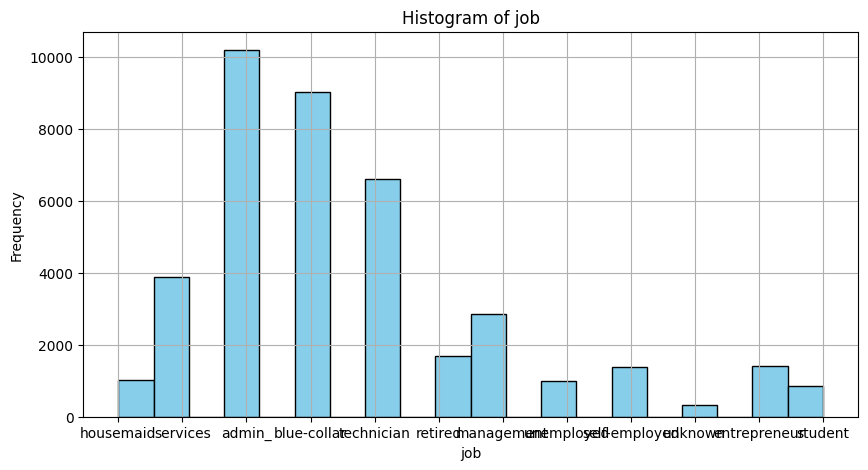

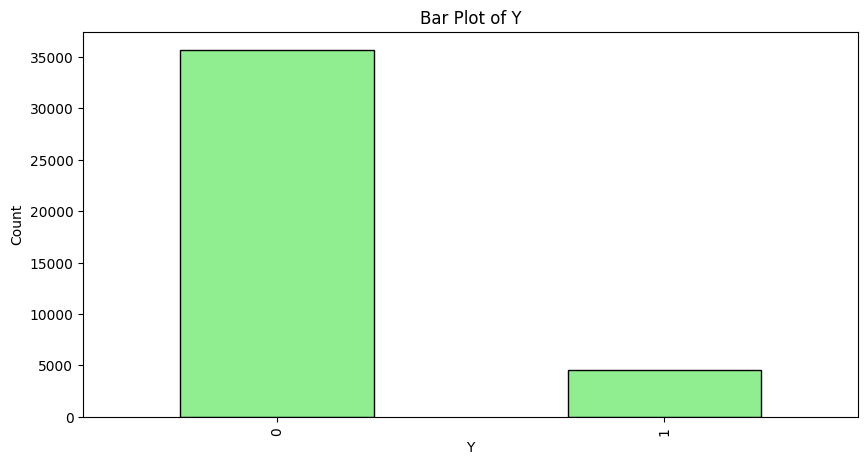

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram for 'duration'
plt.figure(figsize=(10, 5))
plt.hist(df_pd['job'], bins=20, edgecolor='black', color='skyblue')
plt.title('Histogram of job')
plt.xlabel('job')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot histogram for 'y' (only if it's numeric or categorical with few values)
plt.figure(figsize=(10, 5))
if df_pd['y'].dtype == 'object' or len(df_pd['y'].unique()) < 10:
    df_pd['y'].value_counts().plot(kind='bar', color='lightgreen', edgecolor='black')
    plt.title('Bar Plot of Y')
    plt.xlabel('Y')
    plt.ylabel('Count')
else:
    plt.hist(df_pd['y'], bins=20, edgecolor='black', color='lightgreen')
    plt.title('Histogram of Y')
    plt.xlabel


In [ ]:
dtrain, dtest = df.randomSplit([0.7, 0.3], seed = 1234)

In [ ]:
# Replace dots or other special characters in column names
def clean_column_names(df):
    for col_name in df.columns:
        clean_name = col_name.replace('.', '_')
        df = df.withColumnRenamed(col_name, clean_name)
    return df

dtrain = clean_column_names(dtrain)
dtest = clean_column_names(dtest)


In [ ]:
dummy_cols_job, ref_category_job = add_dummy_variables('job', 0)
dummy_cols_marital, ref_category_marital = add_dummy_variables('marital', 0)
dummy_cols_education, ref_category_education = add_dummy_variables('education', 0)
dummy_cols_default, ref_category_default = add_dummy_variables('default', 0)
dummy_cols_housing, ref_category_housing = add_dummy_variables('housing', 0)
dummy_cols_loan, ref_category_loan = add_dummy_variables('loan', 0)

Reference category (dummy omitted): admin_
Reference category (dummy omitted): divorced
Reference category (dummy omitted): basic_4y
Reference category (dummy omitted): no
Reference category (dummy omitted): no
Reference category (dummy omitted): no


In [ ]:
dtrain_pd = dtrain.toPandas()

In [ ]:
# assembling predictors
conti_cols = ['age',
 'campaign', 'duration']

assembler_predictors = (
    conti_cols + dummy_cols_job + dummy_cols_marital + dummy_cols_education +
    dummy_cols_default + dummy_cols_housing + dummy_cols_loan
)

In [ ]:
dtrain_pd = dtrain_pd[['y'] + assembler_predictors]

In [ ]:
dtrain_pd['y'].value_counts()

,count
y,
0,24981
1,3156


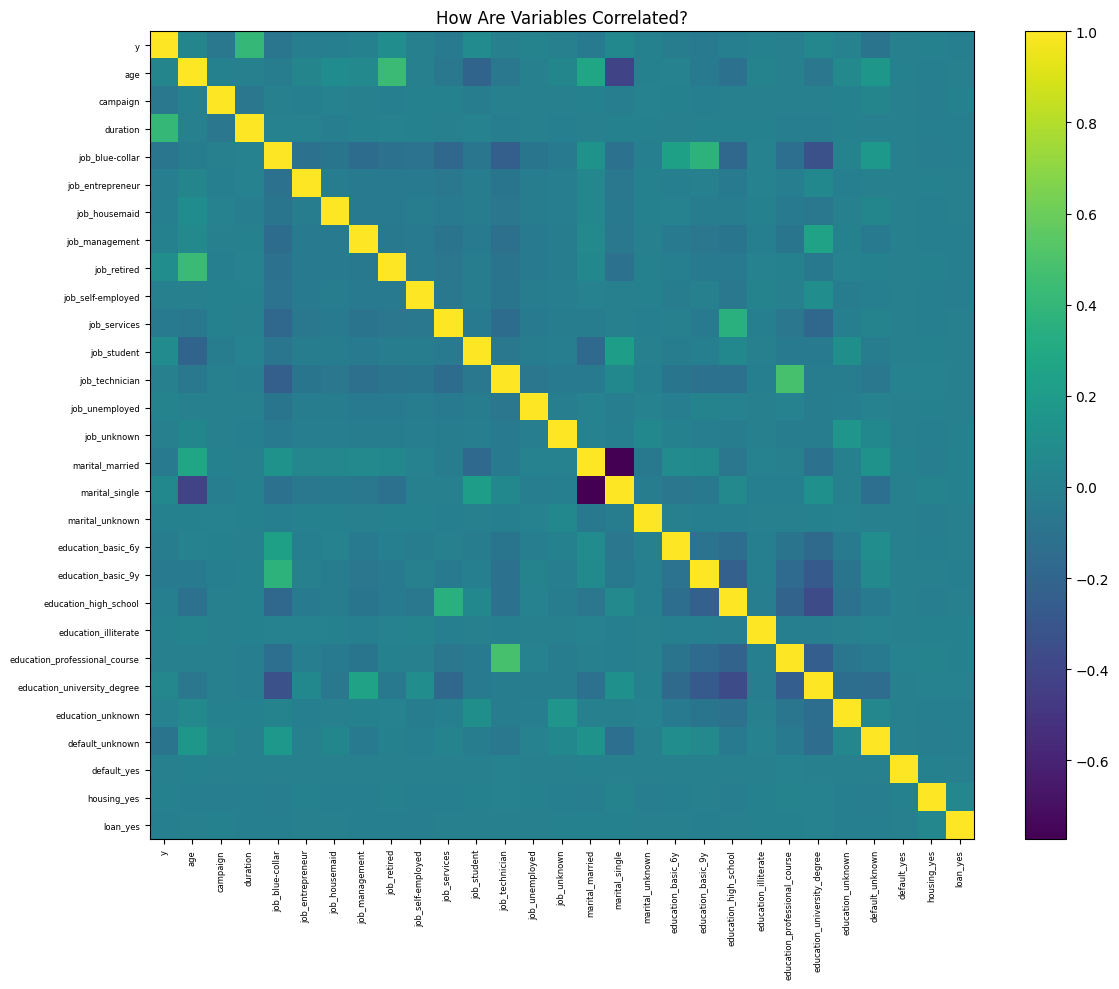

In [ ]:
# Compute correlation matrix
corr_matrix = dtrain_pd.corr()

# 3. Correlation heatmap using matplotlib
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(corr_matrix.values, aspect='auto')
fig.colorbar(cax, ax=ax)
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=90, fontsize=6)
ax.set_yticklabels(corr_matrix.columns, fontsize=6)
plt.title('How Are Variables Correlated?')
plt.tight_layout()
plt.show()

In [ ]:
dtrain_pd['y'].unique()

array([0, 1])

#Linear Regression


In [ ]:
# assembling predictors
conti_cols = ['age',
 'campaign', 'duration']

assembler_predictors = (
    conti_cols + dummy_cols_job + dummy_cols_marital + dummy_cols_education +
    dummy_cols_default + dummy_cols_housing + dummy_cols_loan
)

assembler_1 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)

dtrain_1 = assembler_1.transform(dtrain)
dtest_1  = assembler_1.transform(dtest)

# training model
model_1 = (
    LinearRegression(featuresCol="predictors",
                     labelCol="y")
    .fit(dtrain_1)
)

# making prediction
dtest_1 = model_1.transform(dtest_1)

# makting regression table
print( regression_table(model_1, assembler_1) )

+-------------------------------+--------+------+------------+---------+--------------+--------------+
| y: y                          |   Beta | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+-------------------------------+--------+------+------------+---------+--------------+--------------+
| age                           |  0.001 | ***  |      0.001 |   0.000 |        0.000 |        0.003 |
| campaign                      | -0.004 | ***  |      0.000 |   0.000 |       -0.004 |       -0.004 |
| duration                      |  0.000 | ***  |      0.006 |   0.000 |       -0.012 |        0.013 |
| job_blue-collar               | -0.037 | ***  |      0.010 |   0.000 |       -0.056 |       -0.018 |
| job_entrepreneur              | -0.042 | ***  |      0.012 |   0.000 |       -0.065 |       -0.019 |
| job_housemaid                 | -0.004 |      |      0.007 |   0.752 |       -0.018 |        0.011 |
| job_management                | -0.020 | ***  |      0.010 |   0.006 | 

In [ ]:
model_1.coefficients

DenseVector([0.0013, -0.0035, 0.0005, -0.0374, -0.0419, -0.0037, -0.0201, 0.1075, -0.0253, -0.0327, 0.1416, -0.0156, 0.0326, -0.0047, 0.0176, 0.0444, 0.0437, -0.0003, -0.0144, -0.0056, 0.0958, 0.0079, 0.0218, 0.0165, -0.0604, -0.0736, 0.006, -0.0044])

In [ ]:
model_1.intercept

-0.06683007113139161

In [ ]:
model_1.summary.coefficientStandardErrors

[0.00020689461514424284,
 0.0006171705306687189,
 6.599702383709366e-06,
 0.006268239893884113,
 0.009681367787816423,
 0.01173249429334274,
 0.007295164229308897,
 0.010315055581847624,
 0.0098437016156203,
 0.006786817771694096,
 0.012461643911155625,
 0.006031975051815466,
 0.01138068449212235,
 0.01904501315154409,
 0.005552481450653328,
 0.006387718004761517,
 0.036970486611913794,
 0.009030199308073547,
 0.007210150938291389,
 0.0074432359151217105,
 0.07584875779542072,
 0.008384793168323442,
 0.007555834890730833,
 0.010246290779180421,
 0.004360092449459194,
 0.2830236103087795,
 0.003390331336245513,
 0.004678154223777586,
 0.013597780445066956]

#Logistic Regression

In [ ]:
# assembling predictors
x_cols = ['age',
 'campaign', 'duration']

assembler_predictors = (
    conti_cols + dummy_cols_job + dummy_cols_marital + dummy_cols_education +
    dummy_cols_default + dummy_cols_housing + dummy_cols_loan
)

assembler_1 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)

dtrain_1 = assembler_1.transform(dtrain)
dtest_1  = assembler_1.transform(dtest)

# training the model
model_1 = (
    GeneralizedLinearRegression(featuresCol="predictors",
                                labelCol="y",
                                family="binomial",
                                link="logit")
    .fit(dtrain_1)
)

In [ ]:
# making prediction on both training and test
dtrain_1 = model_1.transform(dtrain_1)
dtest_1 = model_1.transform(dtest_1)

In [ ]:
model_1.summary

Coefficients:
             Feature Estimate   Std Error  T Value P Value
         (Intercept)  -3.8238      0.1770 -21.6010  0.0000
                 age   0.0151      0.0026   5.8379  0.0000
            campaign  -0.1296      0.0131  -9.9012  0.0000
            duration   0.0040      0.0001  52.0245  0.0000
     job_blue-collar  -0.5617      0.0856  -6.5638  0.0000
    job_entrepreneur  -0.5592      0.1362  -4.1043  0.0000
       job_housemaid  -0.0275      0.1514  -0.1816  0.8559
      job_management  -0.2330      0.0898  -2.5928  0.0095
         job_retired   0.8392      0.1080   7.7732  0.0000
   job_self-employed  -0.2974      0.1275  -2.3328  0.0197
        job_services  -0.4705      0.0944  -4.9859  0.0000
         job_student   1.0812      0.1163   9.2963  0.0000
      job_technician  -0.1934      0.0743  -2.6012  0.0093
      job_unemployed   0.3868      0.1281   3.0187  0.0025
         job_unknown  -0.0458      0.2466  -0.1859  0.8526
     marital_married   0.2190      0.0752 

#Regularized Logistic Regression



In [ ]:
# Below is for an interactive display of Pandas DataFrame in Colab
from google.colab import data_table
data_table.enable_dataframe_formatter()

import pandas as pd
import numpy as np
from tabulate import tabulate  # for table summary
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # for lowess smoothing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, pow, mean, avg, when, log, sqrt, exp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
df_pd

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic_4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high_school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high_school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin_,married,basic_6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high_school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional_course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional_course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university_degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,professional_course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


In [ ]:
dtrain, dtest = df.randomSplit([0.7, 0.3], seed = 1234)

In [ ]:
df_pd['job'].unique()

array(['housemaid', 'services', 'admin_', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

In [ ]:
df_pd['marital'].unique()

array(['married', 'single', 'divorced', 'unknown'], dtype=object)

In [ ]:
df_pd['education'].unique()

array(['basic_4y', 'high_school', 'basic_6y', 'basic_9y',
       'professional_course', 'unknown', 'university_degree',
       'illiterate'], dtype=object)

In [ ]:
df_pd['default'].unique()

array(['no', 'unknown', 'yes'], dtype=object)

In [ ]:
df_pd['housing'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
df_pd['loan'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
# Example usage with category_order:
# custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
# dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

custom_order_job = ['admin_','housemaid', 'services', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student']
custom_order_marital = ['divorced', 'married', 'single', 'unknown']
custom_order_education = ['basic_4y', 'high_school', 'basic_6y', 'basic_9y',
       'professional_course', 'unknown', 'university_degree',
       'illiterate']
custom_order_default = ['no', 'unknown', 'yes']
custom_order_housing = ['no', 'yes']
custom_order_loan = ['no', 'yes']
dummy_cols_job, ref_category_job = add_dummy_variables('job', 0, category_order = custom_order_job)
dummy_cols_marital, ref_category_marital = add_dummy_variables('marital', 0, category_order = custom_order_marital)
dummy_cols_education, ref_category_education = add_dummy_variables('education', 0, category_order = custom_order_education)
dummy_cols_default, ref_category_default = add_dummy_variables('default', 0, category_order = custom_order_default)
dummy_cols_housing, ref_category_housing = add_dummy_variables('housing', 0, category_order = custom_order_housing)
dummy_cols_loan, ref_category_loan = add_dummy_variables('loan', 0, category_order = custom_order_loan)

Reference category (dummy omitted): admin_
Reference category (dummy omitted): divorced
Reference category (dummy omitted): basic_4y
Reference category (dummy omitted): no
Reference category (dummy omitted): no
Reference category (dummy omitted): no


In [ ]:
# Keep the name assembler_predictors unchanged,
#   as it will be used as a global variable in the marginal_effects UDF.
conti_cols = ['age',
 'campaign', 'duration']

assembler_predictors = (
    conti_cols + dummy_cols_job + dummy_cols_marital + dummy_cols_education +
    dummy_cols_default + dummy_cols_housing + dummy_cols_loan
)

assembler_1 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)

dtrain_1 = assembler_1.transform(dtrain)
dtest_1  = assembler_1.transform(dtest)

In [ ]:
# training the model
model_1 = (
    GeneralizedLinearRegression(featuresCol="predictors",
                                labelCol="y",
                                family="binomial",
                                link="logit")
    .fit(dtrain_1)
)

In [ ]:
# making prediction on both training and test
dtrain_1 = model_1.transform(dtrain_1)
dtest_1 = model_1.transform(dtest_1)

#dtrain_1 = dtrain_1.withColumnRenamed("prediction", "prediction_lr")
#dtest_1 = dtest_1.withColumnRenamed("prediction", "prediction_lr")

In [ ]:
model_1.summary

Coefficients:
             Feature Estimate   Std Error  T Value P Value
         (Intercept)  -3.8238      0.1770 -21.6010  0.0000
                 age   0.0151      0.0026   5.8379  0.0000
            campaign  -0.1296      0.0131  -9.9012  0.0000
            duration   0.0040      0.0001  52.0245  0.0000
       job_housemaid  -0.0275      0.1514  -0.1816  0.8559
        job_services  -0.4705      0.0944  -4.9859  0.0000
     job_blue-collar  -0.5617      0.0856  -6.5638  0.0000
      job_technician  -0.1934      0.0743  -2.6012  0.0093
         job_retired   0.8392      0.1080   7.7732  0.0000
      job_management  -0.2330      0.0898  -2.5928  0.0095
      job_unemployed   0.3868      0.1281   3.0187  0.0025
   job_self-employed  -0.2974      0.1275  -2.3328  0.0197
         job_unknown  -0.0458      0.2466  -0.1859  0.8526
    job_entrepreneur  -0.5592      0.1362  -4.1043  0.0000
         job_student   1.0812      0.1163   9.2963  0.0000
     marital_married   0.2190      0.0752 

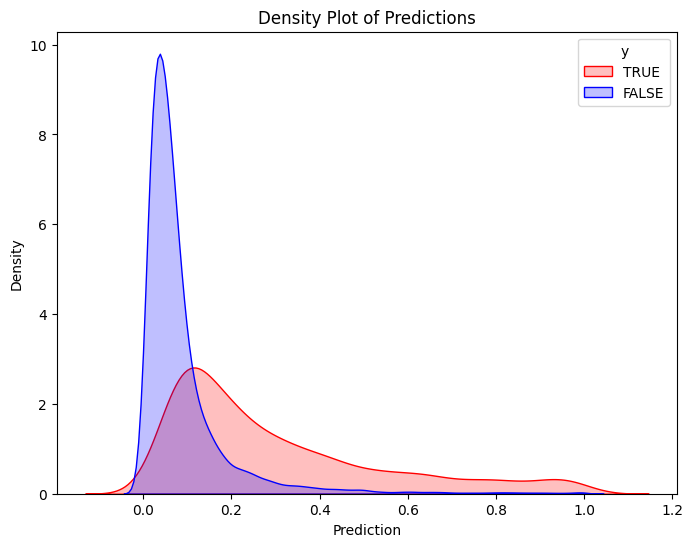

In [ ]:
# Filter training data for atRisk == 1 and atRisk == 0
pdf = dtrain_1.select("prediction", "y").toPandas()

train_true = pdf[pdf["y"] == 1]
train_false = pdf[pdf["y"] == 0]

# Create the first density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(train_true["prediction"], label="TRUE", color="red", fill=True)
sns.kdeplot(train_false["prediction"], label="FALSE", color="blue", fill=True)
plt.xlabel("Prediction")
plt.ylabel("Density")
plt.title("Density Plot of Predictions")
plt.legend(title="y")
plt.show()


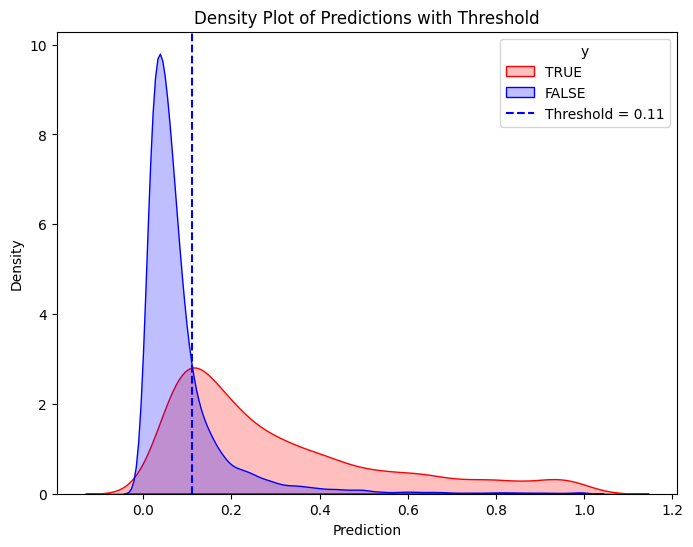

In [ ]:

# Define threshold for vertical line
threshold = 0.11  # Replace with actual value

# Create the second density plot with vertical line
plt.figure(figsize=(8, 6))
sns.kdeplot(train_true["prediction"], label="TRUE", color="red", fill=True)
sns.kdeplot(train_false["prediction"], label="FALSE", color="blue", fill=True)
plt.axvline(x=threshold, color="blue", linestyle="dashed", label=f"Threshold = {threshold}")
plt.xlabel("Prediction")
plt.ylabel("Density")
plt.title("Density Plot of Predictions with Threshold")
plt.legend(title="y")
plt.show()

In [ ]:
# Compute confusion matrix
dtest_1 = dtest_1.withColumn("predicted_class", when(col("prediction") > threshold, 1).otherwise(0))
conf_matrix = dtest_1.groupBy("y", "predicted_class").count().orderBy("y", "predicted_class")

TP = dtest_1.filter((col("y") == 1) & (col("predicted_class") == 1)).count()
FP = dtest_1.filter((col("y") == 0) & (col("predicted_class") == 1)).count()
FN = dtest_1.filter((col("y") == 1) & (col("predicted_class") == 0)).count()
TN = dtest_1.filter((col("y") == 0) & (col("predicted_class") == 0)).count()

accuracy = (TP + TN) / (TP + FP + FN + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
average_rate = (TP + FN) / (TP + TN + FP + FN)  # Proportion of actual at-risk babies
enrichment = precision / average_rate


# Print formatted confusion matrix with labels
print("\n Confusion Matrix:\n")
print("                     Predicted")
print("            |  Negative  |  Positive  ")
print("------------+------------+------------")
print(f"Actual Neg. |    {TN:5}   |    {FP:5}  |")
print("------------+------------+------------")
print(f"Actual Pos. |    {FN:5}   |    {TP:5}  |")
print("------------+------------+------------")


print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity:  {specificity:.4f}")
print(f"Average Rate: {average_rate:.4f}")
print(f"Enrichment:   {enrichment:.4f} (Relative Precision)")


 Confusion Matrix:

                     Predicted
            |  Negative  |  Positive  
------------+------------+------------
Actual Neg. |     8496   |     2188  |
------------+------------+------------
Actual Pos. |      323   |     1054  |
------------+------------+------------
Accuracy:  0.7918
Precision: 0.3251
Recall (Sensitivity): 0.7654
Specificity:  0.7952
Average Rate: 0.1142
Enrichment:   2.8476 (Relative Precision)


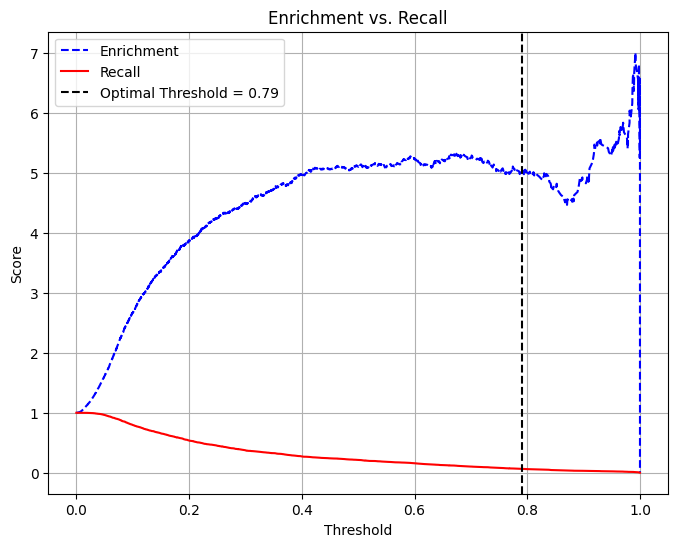

In [ ]:
pdf = dtest_1.select("prediction", "y").toPandas()

# Extract predictions and true labels
y_true = pdf["y"]  # True labels
y_scores = pdf["prediction"]  # Predicted probabilities

# Compute precision, recall, and thresholds
precision_plot, recall_plot, thresholds = precision_recall_curve(y_true, y_scores)

# Compute enrichment: precision divided by average at-risk rate
average_rate = np.mean(y_true)
enrichment_plot = precision_plot / average_rate

# Define optimal threshold (example: threshold where recall ≈ enrichment balance)
threshold = 0.79  # Adjust based on the plot

# Plot Enrichment vs. Recall vs. Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, enrichment_plot[:-1], label="Enrichment", color="blue", linestyle="--")
plt.plot(thresholds, recall_plot[:-1], label="Recall", color="red", linestyle="-")

# Add vertical line for chosen threshold
plt.axvline(x=threshold, color="black", linestyle="dashed", label=f"Optimal Threshold = {threshold}")

# Labels and legend
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Enrichment vs. Recall")
plt.legend()
plt.grid(True)
plt.show()

AUC: 0.8609


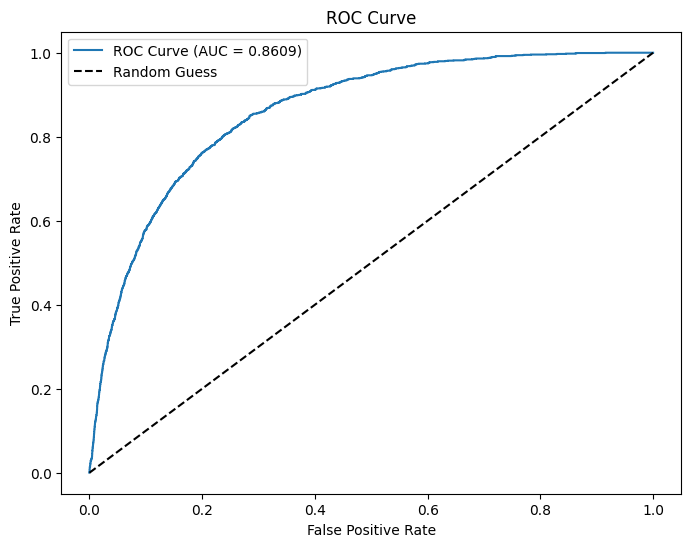

In [ ]:
# Use probability of the positive class (y=1)
evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction", metricName="areaUnderROC")

# Evaluate AUC
auc = evaluator.evaluate(dtest_1)

print(f"AUC: {auc:.4f}")  # Higher is better (closer to 1)

# Convert to Pandas
pdf = dtest_1.select("prediction", "y").toPandas()

# Compute ROC curve
fpr, tpr, _ = roc_curve(pdf["y"], pdf["prediction"])

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#Lasso Logistic Regression

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [ ]:
dtrain_pd = dtrain.toPandas()
dtest_pd = dtest.toPandas()

In [ ]:
assembler_predictors

['age',
 'campaign',
 'duration',
 'job_housemaid',
 'job_services',
 'job_blue-collar',
 'job_technician',
 'job_retired',
 'job_management',
 'job_unemployed',
 'job_self-employed',
 'job_unknown',
 'job_entrepreneur',
 'job_student',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_high_school',
 'education_basic_6y',
 'education_basic_9y',
 'education_professional_course',
 'education_unknown',
 'education_university_degree',
 'education_illiterate',
 'default_unknown',
 'default_yes',
 'housing_yes',
 'loan_yes']

In [ ]:
dtrain_pd = dtrain_pd[assembler_predictors+['y']]
dtest_pd = dtest_pd[assembler_predictors+['y']]

In [ ]:
dtrain_pd

,age,campaign,duration,job_housemaid,job_services,job_blue-collar,job_technician,job_retired,job_management,job_unemployed,...,education_basic_9y,education_professional_course,education_unknown,education_university_degree,education_illiterate,default_unknown,default_yes,housing_yes,loan_yes,y
0,20,1,285,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,20,2,217,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20,3,598,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20,1,680,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,20,15,97,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28132,92,1,1064,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,1
28133,92,1,370,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,1
28134,94,1,134,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
28135,95,1,85,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_train = dtrain_pd['y']
y_test = dtest_pd['y']

In [ ]:
X_train = dtrain_pd[assembler_predictors]
X_test = dtest_pd[assembler_predictors]

In [ ]:
# Revised LogisticRegressionCV with fewer candidate Cs, fewer folds, and looser tolerance:
lasso_cv = LogisticRegressionCV(
    Cs=10,         # Fewer candidate values
    cv=3,          # Fewer CV folds
    penalty='l1',
    solver='saga',
    max_iter=1000,
    tol=1e-3,      # Looser tolerance for faster convergence
    scoring='neg_log_loss'
)
lasso_cv.fit(X_train.values, y_train.values)

print("Best alpha:", 1 / lasso_cv.C_[0])

intercept = float(lasso_cv.intercept_[0])
coef_lasso = pd.DataFrame({
    'predictor': list(X_train.columns),
    'coefficient': list(lasso_cv.coef_[0]),
    'exp_coefficient': np.exp( list(lasso_cv.coef_[0]) ),
})

Best alpha: 0.0001


In [ ]:
np.exp(lasso_cv.intercept_[0])

np.float64(0.9389862225540642)

In [ ]:
coef_lasso = coef_lasso.query('coefficient != 0')

In [ ]:
intercept

-0.06295447234790122

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

Lasso Regression Coefficients:
                        predictor  coefficient
0                             age    -0.033978
1                        campaign    -0.235021
2                        duration     0.003321
3                   job_housemaid     0.000206
4                    job_services    -0.093253
5                 job_blue-collar    -0.281852
6                  job_technician    -0.047449
7                     job_retired     0.182412
8                  job_management    -0.003973
9                  job_unemployed     0.003045
10              job_self-employed    -0.005532
11                    job_unknown    -0.000251
12               job_entrepreneur    -0.011212
13                    job_student     0.019067
14                marital_married    -0.143780
15                 marital_single    -0.090573
16                marital_unknown     0.000143
17          education_high_school    -0.115260
18             education_basic_6y    -0.016910
19             education_basi

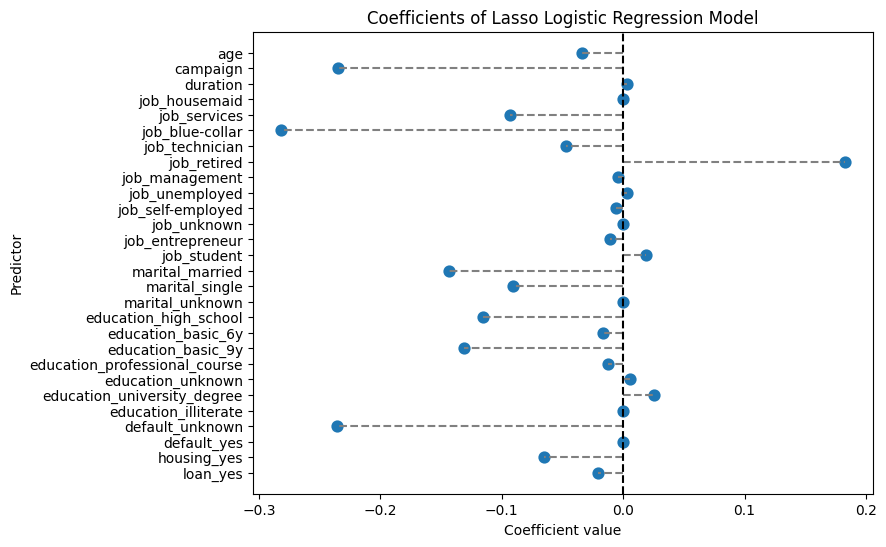

Confusion Matrix (Lasso):
 [[10525   159]
 [ 1131   246]]
Lasso Accuracy: 0.8930436945526905
Lasso Precision: 0.6074074074074074
Lasso Recall: 0.1786492374727669


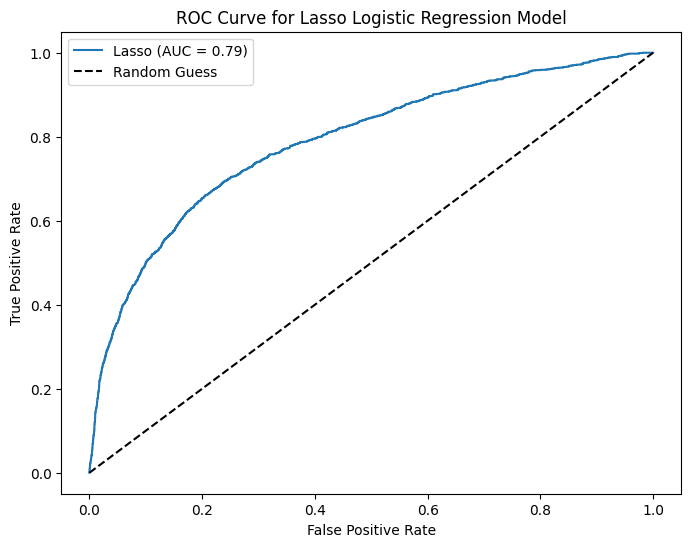

In [ ]:
# Note: solver='saga' supports L1 regularization.
lasso_cv = LogisticRegressionCV(
    Cs=100, cv=5, penalty='l1', solver='saga', max_iter=1000, scoring='neg_log_loss'
)
lasso_cv.fit(X_train, y_train)

intercept = float(lasso_cv.intercept_)
coef_lasso = pd.DataFrame({
    'predictor': list(X_train.columns),
    'coefficient': list(lasso_cv.coef_[0])
})

print("Lasso Regression Coefficients:")
print(coef_lasso)

# Force an order for the y-axis (using the feature names as they appear in coef_lasso)
order = coef_lasso['predictor'].tolist()

plt.figure(figsize=(8,6))
ax = sns.pointplot(x="coefficient", y="predictor", data=coef_lasso, order=order, join=False)
plt.title("Coefficients of Lasso Logistic Regression Model")
plt.xlabel("Coefficient value")
plt.ylabel("Predictor")

# Draw horizontal lines from 0 to each coefficient.
for _, row in coef_lasso.iterrows():
    # Get the y-axis position from the order list.
    y_pos = order.index(row['predictor'])
    plt.hlines(y=y_pos, xmin=0, xmax=row['coefficient'], color='gray', linestyle='--')

# Draw a vertical line at 0.
plt.axvline(0, color='black', linestyle='--')

plt.show()

# Prediction and evaluation for lasso model
y_pred_prob_lasso = lasso_cv.predict_proba(X_test)[:, 1]
y_pred_lasso = (y_pred_prob_lasso > 0.5).astype(int)
ctab_lasso = confusion_matrix(y_test, y_pred_lasso)
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
precision_lasso = precision_score(y_test, y_pred_lasso)
recall_lasso = recall_score(y_test, y_pred_lasso)
auc_lasso = roc_auc_score(y_test, y_pred_prob_lasso)

print("Confusion Matrix (Lasso):\n", ctab_lasso)
print("Lasso Accuracy:", accuracy_lasso)
print("Lasso Precision:", precision_lasso)
print("Lasso Recall:", recall_lasso)


# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lasso)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Lasso (AUC = {auc_lasso:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Lasso Logistic Regression Model')
plt.legend(loc='best')
plt.show()

#Prunned Tree

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.inspection import PartialDependenceDisplay

Training MSE: 0.078
Test MSE: 0.079


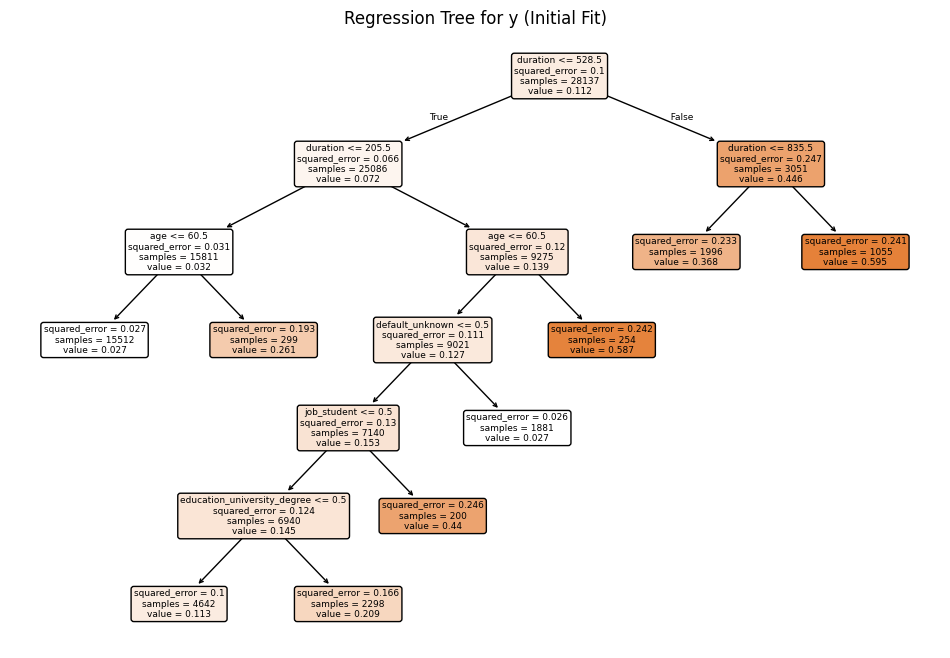

In [ ]:
# In scikit-learn, we can use min_impurity_decrease=0.005 for a similar effect.
tree_model = DecisionTreeRegressor(min_impurity_decrease=0.0005, random_state=42)
# Fit the model using all predictors (all columns except 'medv')
tree_model.fit(X_train, y_train)


# Predict on training and test sets
y_train_pred = tree_model.predict(X_train)
y_test_pred = tree_model.predict(X_test)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print the results
print(f"Training MSE: {mse_train:.3f}")
print(f"Test MSE: {mse_test:.3f}")

# Plot the initial regression tree
plt.figure(figsize=(12, 8))
plot_tree(tree_model, feature_names=X_train.columns, filled=True, rounded=True)
plt.title("Regression Tree for y (Initial Fit)")
plt.show()

#Random Forest

Random Forest Model:
RandomForestRegressor(max_features=5, n_estimators=500, oob_score=True,
                      random_state=42)
Out-of-bag score: 0.17876557294409545
Train MSE: 0.011213214834019861
Test MSE: 0.08252805794007545


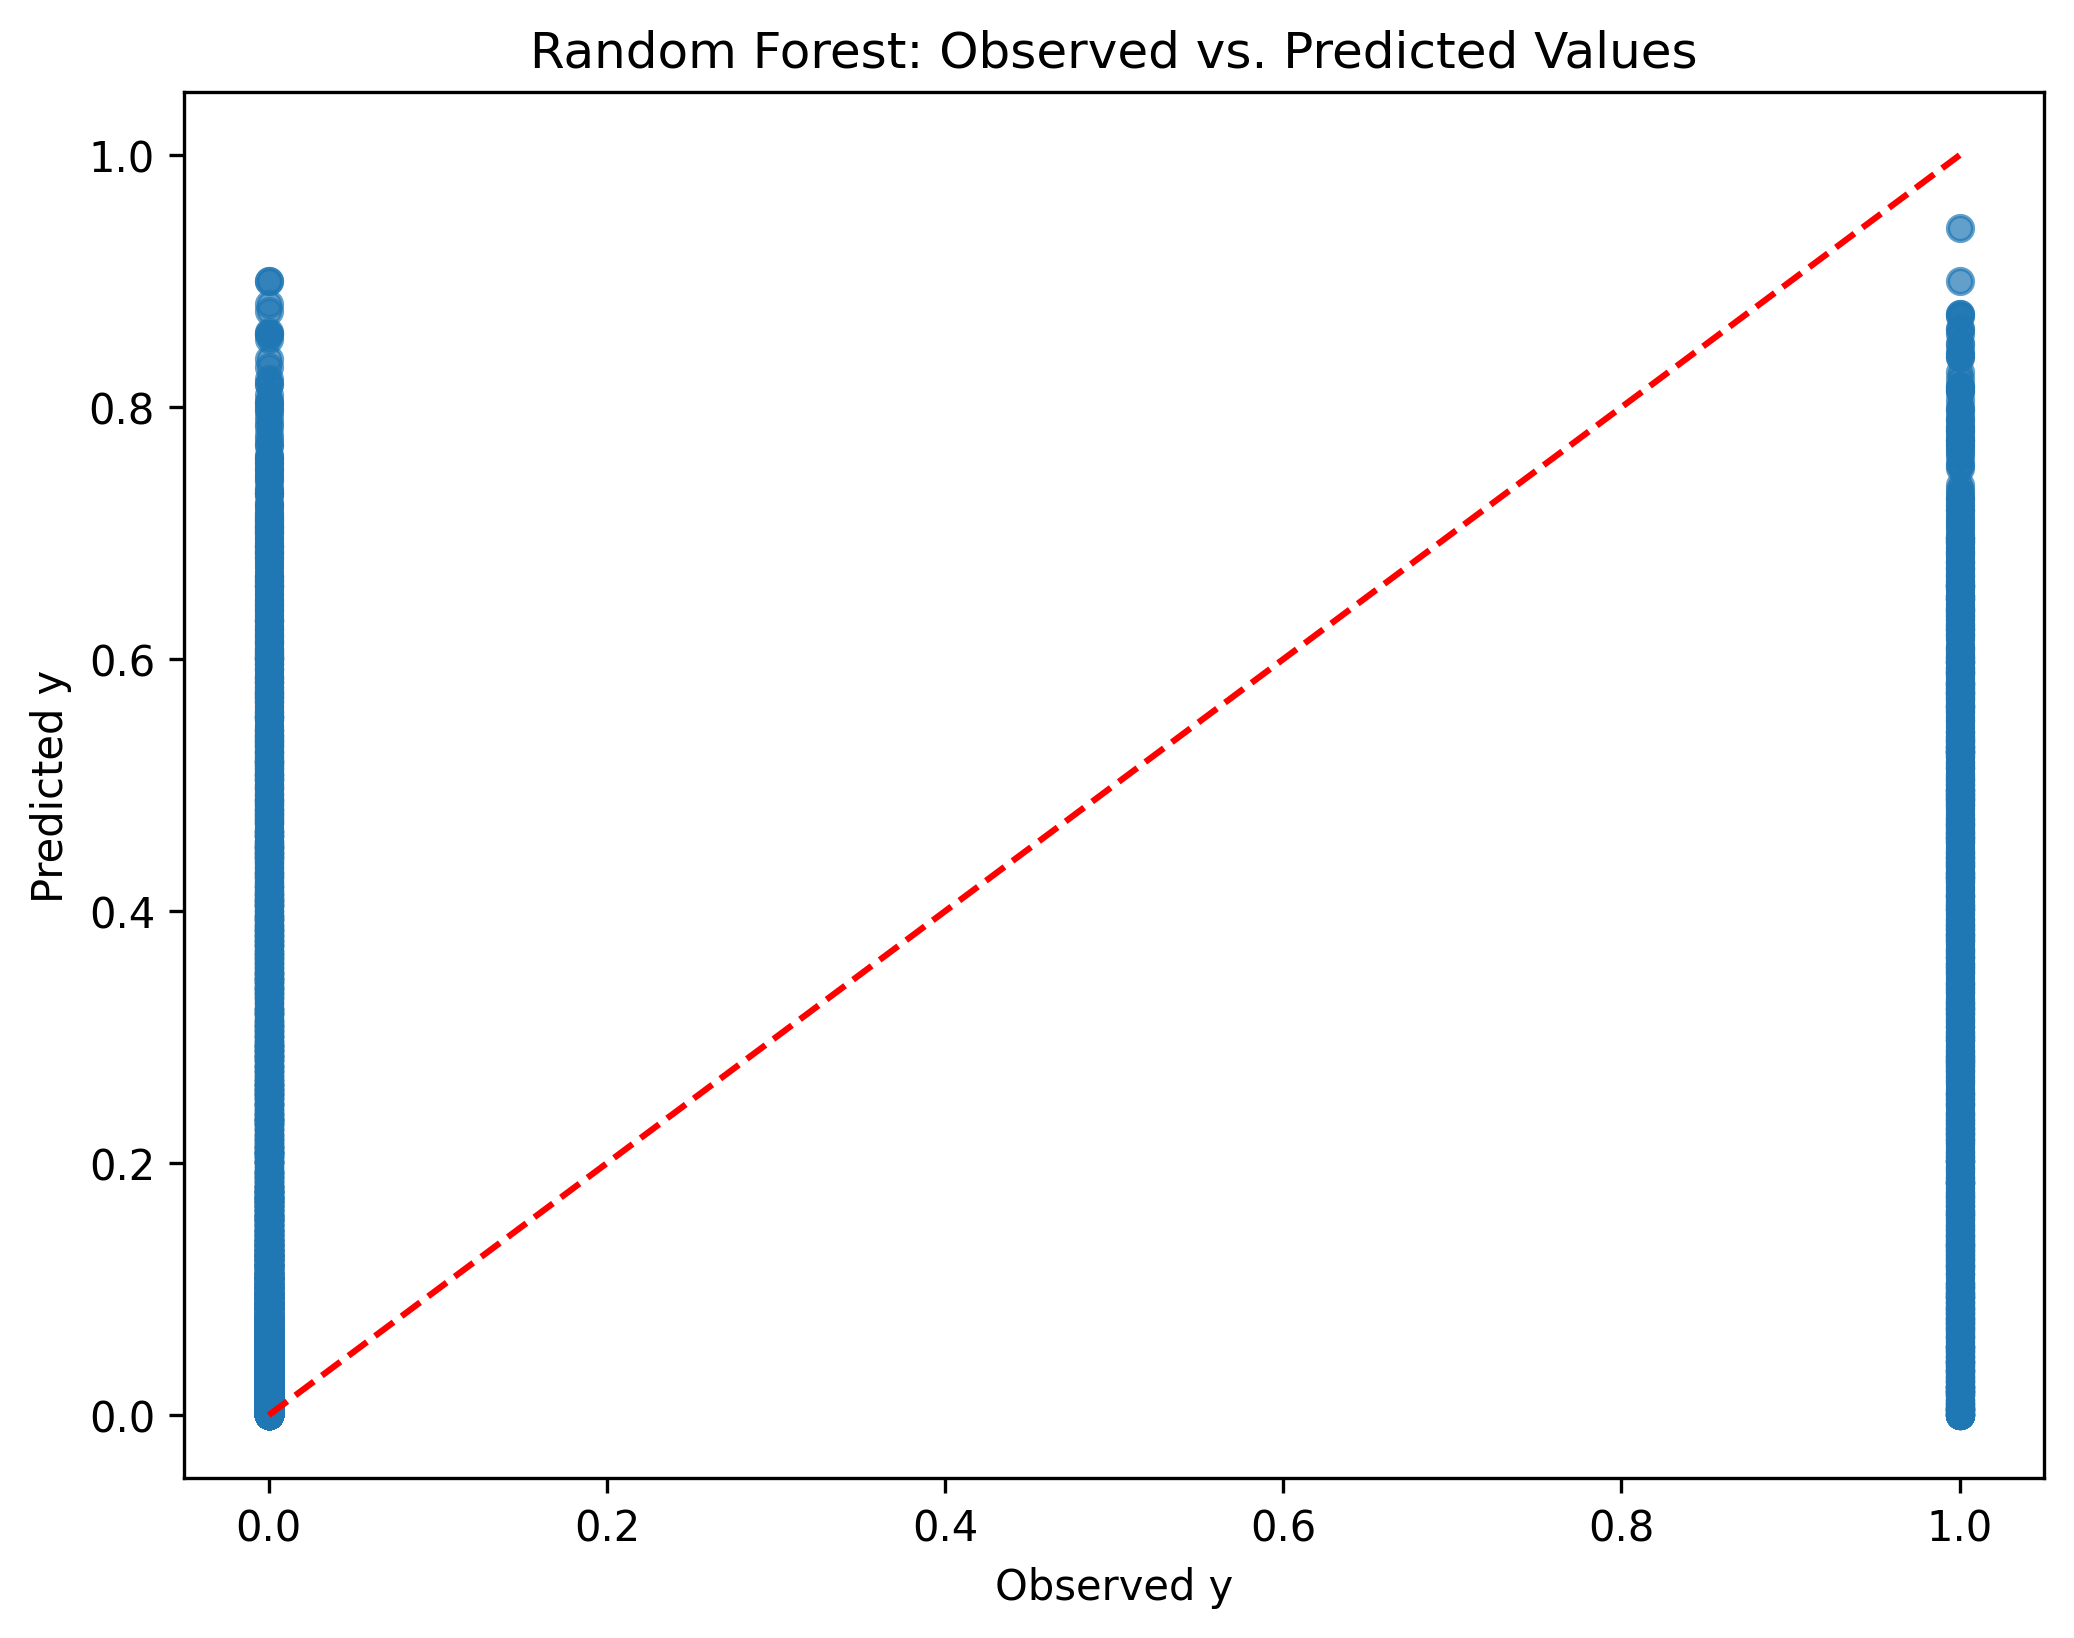

In [ ]:

# Build the Random Forest model
# max_features=13 means that at each split the algorithm randomly considers 13 predictors.
rf = RandomForestRegressor(max_features=5,  # Use 13 features at each split
                           n_estimators=500,  # Number of trees in the forest
                           random_state=42,
                           oob_score=True)    # Use out-of-bag samples to estimate error
rf.fit(X_train, y_train)


# Print the model details
print("Random Forest Model:")
print(rf)

# Output the model details (feature importances, OOB score, etc.)
print("Out-of-bag score:", rf.oob_score_)  # A rough estimate of generalization error


# Generate predictions on training and testing sets
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate Mean Squared Errors (MSE) for both sets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

# Optional: Plot predicted vs. observed values for test data
plt.figure(figsize=(8,6), dpi=300)
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Observed y")
plt.ylabel("Predicted y")
plt.title("Random Forest: Observed vs. Predicted Values")
plt.show()

Variable Importances:
age: 0.2286
campaign: 0.0716
duration: 0.4865
job_services: 0.0059
job_admin_: 0.0100
job_blue-collar: 0.0075
job_technician: 0.0091
job_retired: 0.0071
job_management: 0.0067
job_unemployed: 0.0055
job_self-employed: 0.0048
job_unknown: 0.0020
job_entrepreneur: 0.0045
job_student: 0.0069
marital_single: 0.0143
marital_divorced: 0.0126
marital_unknown: 0.0014
education_high_school: 0.0113
education_basic_6y: 0.0058
education_basic_9y: 0.0085
education_professional_course: 0.0096
education_unknown: 0.0063
education_university_degree: 0.0107
education_illiterate: 0.0004
default_unknown: 0.0137
default_yes: 0.0000
housing_yes: 0.0289
loan_yes: 0.0200


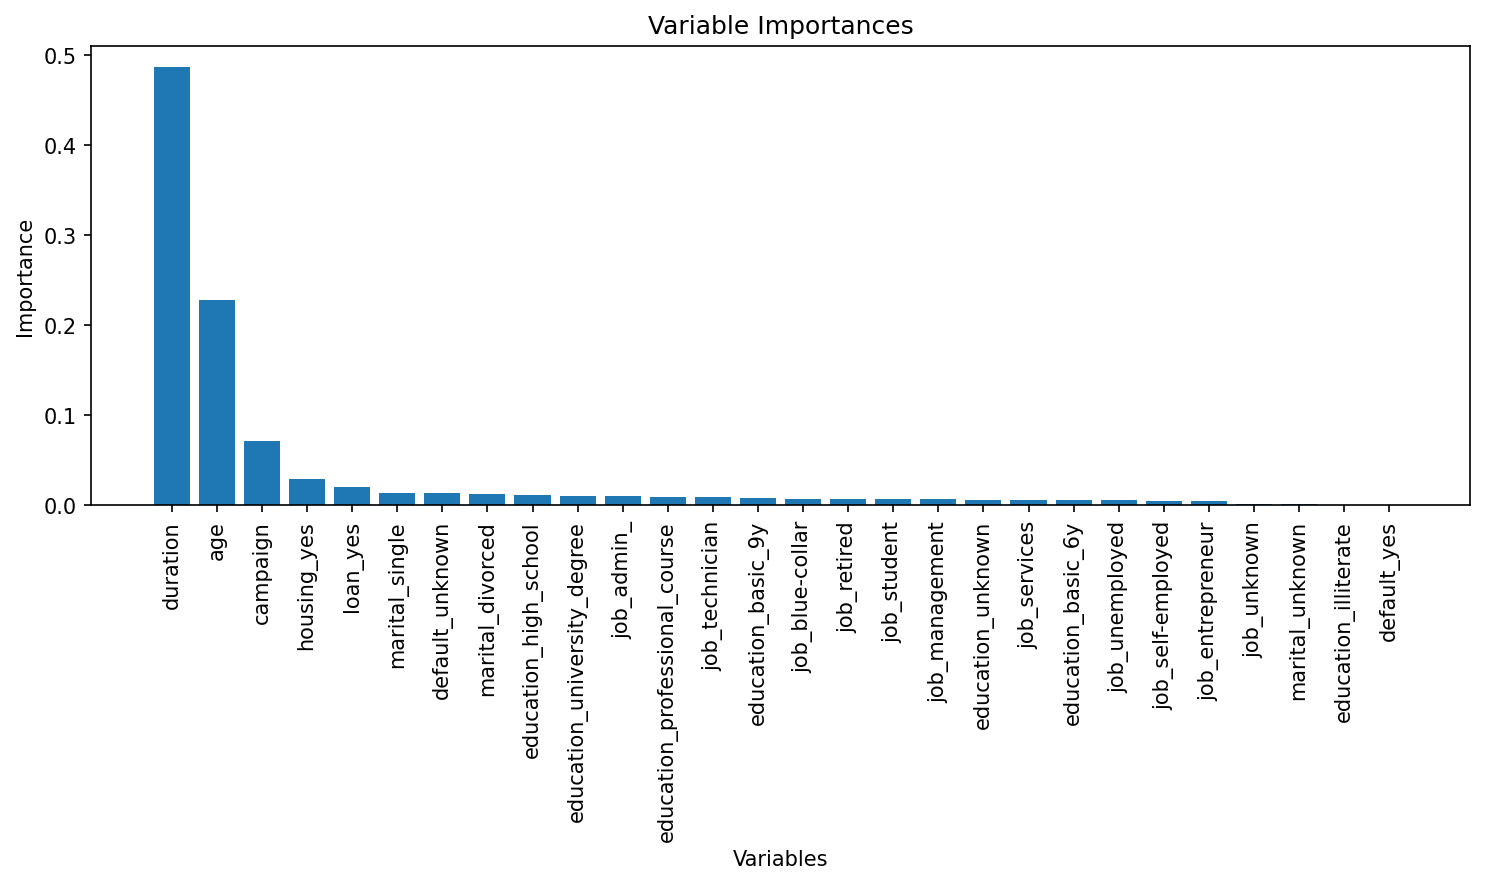

In [ ]:
# Get feature importances from the model (equivalent to importance(bag.boston) in R)
importances = rf.feature_importances_
feature_names = X_train.columns

print("Variable Importances:")
for name, imp in zip(feature_names, importances):
    print(f"{name}: {imp:.4f}")

# Plot the feature importances, similar to varImpPlot(bag.boston) in R
# Sort the features by importance for a nicer plot.
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6), dpi=150)
plt.title("Variable Importances")
plt.bar(range(len(feature_names)), importances[indices], align='center')
plt.xticks(range(len(feature_names)), feature_names[indices], rotation=90)
plt.xlabel("Variables")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

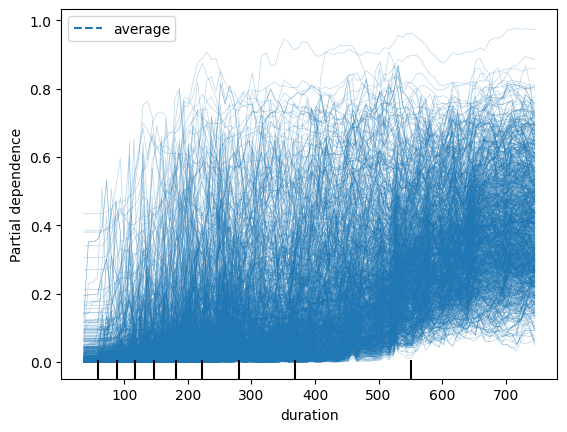

In [ ]:
PartialDependenceDisplay.from_estimator(rf, X_train, ['duration'], kind='both')

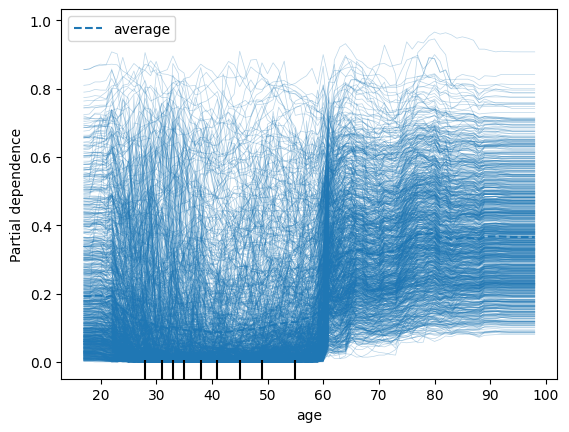

In [ ]:
PartialDependenceDisplay.from_estimator(rf, X_train, ['age'], kind='both')

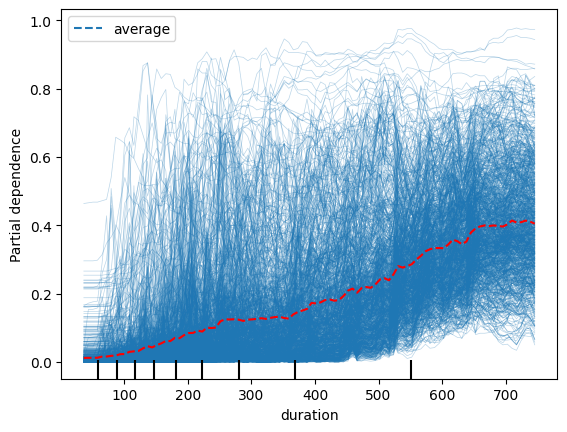

In [ ]:
disp = PartialDependenceDisplay.from_estimator(rf, X_train, ['duration'], kind='both')

# Access the line representing the average PDP (it's typically the last Line2D object)
# and change its color manually
for ax in disp.axes_.ravel():
    lines = ax.get_lines()
    if lines:  # In case the axis has line objects
        # The last line is usually the average PDP
        pdp_line = lines[-1]
        pdp_line.set_color("red")  # Change to any color you like

plt.show()

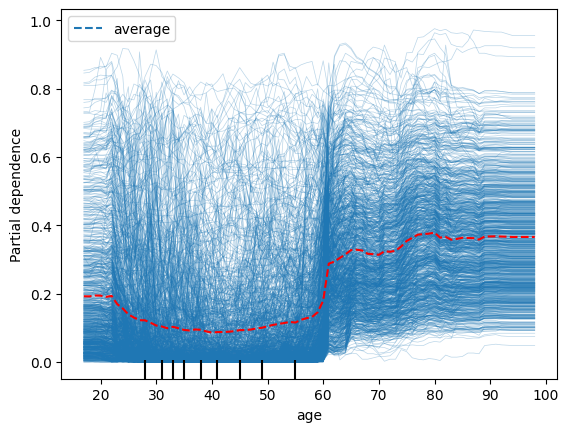

In [ ]:
disp = PartialDependenceDisplay.from_estimator(rf, X_train, ['age'], kind='both')

# Access the line representing the average PDP (it's typically the last Line2D object)
# and change its color manually
for ax in disp.axes_.ravel():
    lines = ax.get_lines()
    if lines:  # In case the axis has line objects
        # The last line is usually the average PDP
        pdp_line = lines[-1]
        pdp_line.set_color("red")  # Change to any color you like

plt.show()

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best Parameters: {'max_features': 3, 'min_samples_leaf': 5}


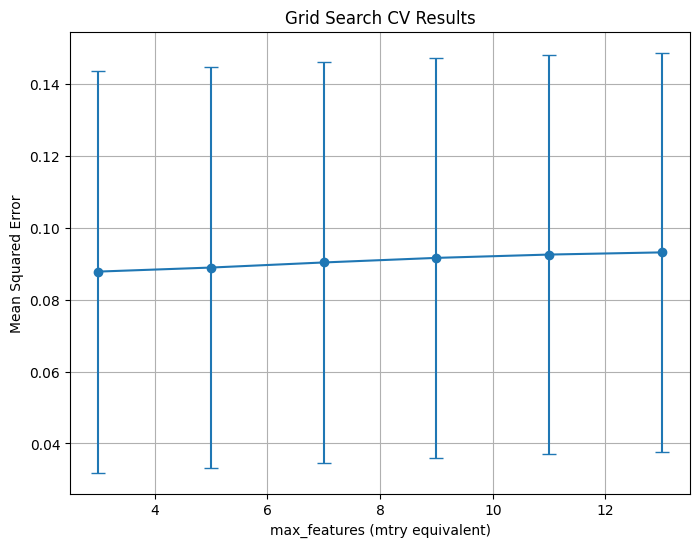

In [ ]:
# Define the grid of hyperparameters:
# - min_samples_leaf is the minimum number of samples in a terminal node.
param_grid = {
    "max_features": list(range(3, 15, 2)),
    "min_samples_leaf": [5]
}

# Initialize the RandomForestRegressor:
# - n_estimators is set to 50 (equivalent to num.trees)
# - random_state is set for reproducibility.
# rf = RandomForestRegressor(n_estimators=50, random_state=1917)

rf = RandomForestRegressor(n_estimators=500,  # Number of trees in the forest
                           random_state=42,
                           oob_score=True)    # Use out-of-bag samples to estimate error

# Set up 10-fold cross-validation and GridSearch over the parameters
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=10,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search on the data
grid_search.fit(X_train, y_train)

# Extract the best parameters
print("Best Parameters:", grid_search.best_params_)

# To replicate the ggplot visualization from R, we plot the grid search results.
results = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(8, 6))
plt.errorbar(
    results["param_max_features"].astype(int),
    -results["mean_test_score"],
    yerr=results["std_test_score"],
    fmt="o-",
    capsize=5
)
plt.title("Grid Search CV Results")
plt.xlabel("max_features (mtry equivalent)")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.show()


#Gradient Boosting

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


<Figure size 1000x800 with 0 Axes>

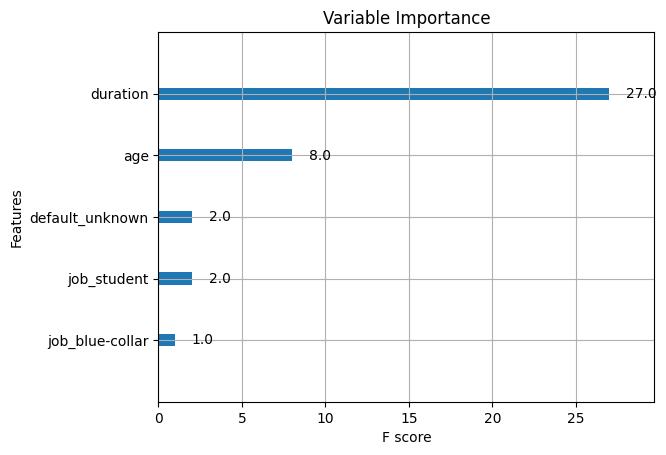

Test MSE: 0.08096029609441757
Best parameters: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 40, 'subsample': 1}


In [ ]:
# Define the grid of hyperparameters
param_grid = {
    "n_estimators": list(range(20, 201, 20)),  # nrounds: 20, 40, ..., 200
    "learning_rate": [0.025, 0.05, 0.1, 0.3],  # eta
    "gamma": [0],                              # gamma
    "max_depth": [1, 2, 3, 4],
    "colsample_bytree": [1],
    "min_child_weight": [1],
    "subsample": [1]
}

# Initialize the XGBRegressor with the regression objective and fixed random state for reproducibility
xgb_reg = XGBRegressor(objective="reg:squarederror", random_state=1937, verbosity=1)

# Set up GridSearchCV with 10-fold cross-validation; scoring is negative MSE
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=10,
    verbose=1  # Adjust verbosity as needed
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Train the final model using the best parameters (grid_search.best_estimator_ is already refit on entire data)
final_model = grid_search.best_estimator_

# Plot variable importance using XGBoost's plot_importance function
plt.figure(figsize=(10, 8))
plot_importance(final_model)
plt.title("Variable Importance")
plt.show()

# Calculate MSE on the test data
y_pred = final_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", test_mse)

# Print the best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best parameters:", best_params)